In [5]:
opt = {
    outchan = 3,
    inchan = 3,
    num_epoch = 10000,
    batchsize = 128,
    valsize = 32,
    gpu = false
}

In [12]:
image = require 'image'

if opt.gpu then
    require 'cutorch'
    require 'cunn'
    inputdir = 'small_faces/'
    truthdir = 'big_faces/'
else
    inputdir = '/home/nicholas/Documents/small_faces/'
    truthdir = '/home/nicholas/Documents/big_faces/'
end

input_imgs = torch.FloatTensor()
label_imgs = torch.FloatTensor()
valinputs = torch.FloatTensor()
vallabels = torch.FloatTensor()

for file in paths.files('./') do
   if file:find('input_imgs.t7' .. '$') then
        input_imgs = torch.load('input_imgs.t7')
   end
   if file:find('label_imgs.t7' .. '$') then
        label_imgs = torch.load('label_imgs.t7')
   end
   if file:find('valinputs.t7' .. '$') then
        valinputs = torch.load('valinputs.t7')
   end
   if file:find('vallabels.t7' .. '$') then
        vallabels = torch.load('vallabels.t7')
   end
end

if input_imgs:nDimension() == 0 then
    print('Loading all images from files')
    inputfiles = {}
    labelfiles = {}
    numExamples = 0
    for file in paths.files(inputdir) do
       if file:find('png' .. '$') then
        table.insert(inputfiles, paths.concat(inputdir,file))
        numExamples = numExamples + 1
       end
    end
    for file in paths.files(truthdir) do
       if file:find('png' .. '$') then
        table.insert(labelfiles, paths.concat(truthdir,file))
       end
    end

    -- Check files
    if #inputfiles == 0 or #labelfiles == 0 then
       error('given directory doesnt contain any files')
    end
    table.sort(inputfiles, function (a,b) return a < b end)
    table.sort(labelfiles, function (a,b) return a < b end)


    -- construct validation set

--     if opt.gpu then
--         valinputs = torch.CudaTensor(opt.valsize, opt.inchan, 16, 16)
--         vallabels = torch.CudaTensor(opt.valsize, opt.outchan, 32, 32)
--     else
    valinputs = torch.FloatTensor(opt.valsize, opt.inchan, 16, 16)
    vallabels = torch.FloatTensor(opt.valsize, opt.outchan, 32, 32)
--     end    

    local n = numExamples
    for vi = 1, opt.valsize do
        local rand_id = torch.random(1, n)
        valinputs[vi] = image.load(table.remove(inputfiles, rand_id))
        vallabels[vi] = image.load(table.remove(labelfiles, rand_id))
        n = n - 1
    end

--     if opt.gpu then
--         input_imgs = torch.CudaTensor(numExamples - opt.valsize, 3, 16, 16)
--         label_imgs = torch.CudaTensor(numExamples - opt.valsize, 3, 32, 32)
--     else
    input_imgs = torch.FloatTensor(numExamples - opt.valsize, 3, 16, 16)
    label_imgs = torch.FloatTensor(numExamples - opt.valsize, 3, 32, 32)
--     end    

    for i,file in ipairs(inputfiles) do 
    --    table.insert(input_imgs, image.load(file))
       input_imgs[i] = image.load(file)
    end


    for i,file in ipairs(labelfiles) do 
    --    table.insert(label_imgs, image.load(file))
       label_imgs[i] = image.load(file)
    end
    torch.save('input_imgs.t7', input_imgs)
    torch.save('label_imgs.t7', label_imgs)
    torch.save('valinputs.t7', valinputs)
    torch.save('vallabels.t7', vallabels)
end

if opt.gpu then
    input_imgs = input_imgs:cuda()
    label_imgs = label_imgs:cuda()
    valinputs = valinputs:cuda()
    vallabels = vallabels:cuda()
end

print('Images loaded')

4	
Images loaded	


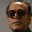

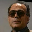

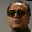

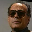

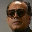

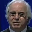

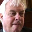

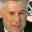

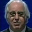

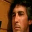

In [4]:
if not opt.gpu then
    for i = 1,5 do
       itorch.image(input_imgs[i])
    end
    for i = 1,5 do
       itorch.image(label_imgs[i])
    end
    for i = 1,5 do
       itorch.image(valinputs[i])
    end
    for i = 1,5 do
       itorch.image(vallabels[i])
    end
end
for i = 1,opt.valsize do
   image.save(('validation/val_img_%d_input.png'):format(i), valinputs[i])
   image.save(('validation/val_img_%d_label.png'):format(i), vallabels[i])
end

In [13]:
require 'nn'

-- input: inchan x 16 x 16
gen = nn.Sequential()
-- gen:add(nn.SpatialFullConvolution(opt.inchan, opt.outchan * 4, 9, 9))
-- gen:add(nn.SpatialBatchNormalization(opt.outchan * 4)):add(nn.ReLU(true))

-- -- size: opt.outchan * 4 x 24 x 24 
-- gen:add(nn.SpatialFullConvolution(opt.outchan * 4, opt.outchan, 9, 9))
-- gen:add(nn.ReLU(true))  

-- -- size: opt.outchan x 32 x 32

gen:add(nn.SpatialFullConvolution(opt.inchan, opt.outchan * 8, 3, 3))
gen:add(nn.SpatialBatchNormalization(opt.outchan * 8)):add(nn.ReLU(true))
-- -- size: opt.outchan * 8 x 18 x 18 

gen:add(nn.SpatialFullConvolution(opt.outchan * 8, opt.outchan * 4, 7, 7))
gen:add(nn.SpatialBatchNormalization(opt.outchan * 4)):add(nn.ReLU(true))
-- size: opt.outchan * 4 x 24 x 24 

gen:add(nn.SpatialFullConvolution(opt.outchan * 4, opt.outchan, 9, 9))
gen:add(nn.ReLU(true))  
-- size: opt.outchan x 32 x 32

if opt.gpu then
    gen:cuda()
end

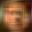

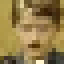

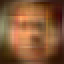

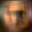

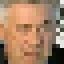

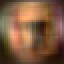

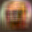

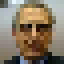

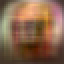

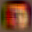

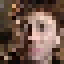

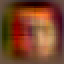


validation error at epoch = 200 is 0.1350 	 Time Taken: 85.927	


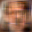

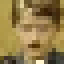

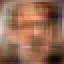

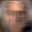

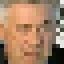

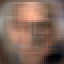

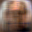

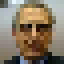

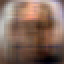

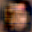

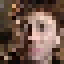

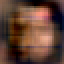


validation error at epoch = 400 is 0.1085 	 Time Taken: 79.558	


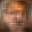

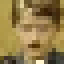

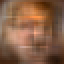

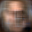

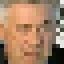

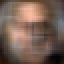

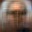

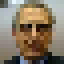

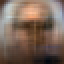

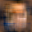

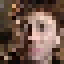

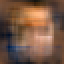


validation error at epoch = 600 is 0.1297 	 Time Taken: 90.581	


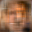

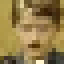

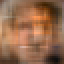

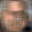

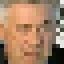

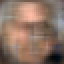

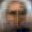

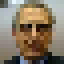

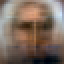

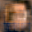

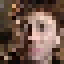

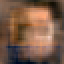


validation error at epoch = 800 is 0.0997 	 Time Taken: 94.413	


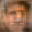

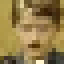

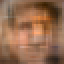

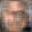

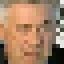

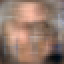

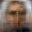

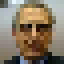

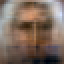

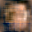

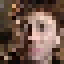

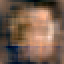


validation error at epoch = 1000 is 0.0908 	 Time Taken: 79.998	


In [ ]:
require 'optim'

-- collectgarbage('setstepmul', 120)
criterion = nn.AbsCriterion()
if opt.gpu then
    criterion:cuda()
end
local optimState = {learningRate = 0.001}

epoch_tm = torch.Timer()
total_tm = torch.Timer()
for epoch = 1, opt.num_epoch do
    
    -- construct batch
    if opt.gpu then
        inputs = torch.CudaTensor(opt.batchsize, opt.inchan, 16, 16)
        labels = torch.CudaTensor(opt.batchsize, opt.outchan, 32, 32)
    else
        inputs = torch.FloatTensor(opt.batchsize, opt.inchan, 16, 16)
        labels = torch.FloatTensor(opt.batchsize, opt.outchan, 32, 32)
    end   
    
    for bi = 1, opt.batchsize do
        local rand_id = torch.random(1, input_imgs:size(1))
        inputs[bi] = input_imgs[rand_id]
        labels[bi] = label_imgs[rand_id]
    end
    
    params, gradParams = gen:getParameters()
    
    -- evaluation, forwards/backward pass
    fGx = function(params)
        gradParams:zero()
        outputs = gen:forward(inputs)

        errG = criterion:forward(outputs, labels)
        df_do = criterion:backward(outputs, labels)
--         df_dg = disc:updateGradInput(inputs, df_do) -- when discriminator is implemented
        gen:backward(inputs, df_do)
        return errG, gradParams
    end
    
    -- train
    optim.sgd(fGx, params, optimState)
    
    -- validate
    if epoch % 200 == 0 then
        outputs = gen:forward(valinputs)
        if not opt.gpu then
            for vi = 1, 4 do
                itorch.image(valinputs[vi])
                itorch.image(outputs[vi])
                itorch.image(image.scale(valinputs[vi], 64, 64, 'simple'))
                itorch.image(image.scale(outputs[vi], 64, 64, 'simple'))
            end
        end
        valerr = criterion:forward(outputs, vallabels)
        print(('\nvalidation error at epoch = %d is %.4f \t Time Taken: %.3f'):format(epoch, valerr, epoch_tm:time().real))
        
--         collectgarbage()
        epoch_tm:reset()
    end
end
print(('\n total time taken: %.3f'):format(total_tm:time().real))
gen:float()
torch.save('srez_model.t7', gen)